In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import os
import random

# --- FIXING RANDOMNESS (REPRODUCIBILITY) ---
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"--- Randomness fixed with seed: {SEED} ---")

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle # We will need to shuffle our new dataset

# Keras Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Add src to path
sys.path.append('../src')
from src.preprocess import normalize_flux
#Import tool--
from src.augmentation import inject_transit_signal

print(f"TensorFlow Version: {tf.__version__}")

--- Randomness fixed with seed: 42 ---
TensorFlow Version: 2.20.0


In [7]:
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'
print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Map labels
df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

# --- 2. Data Augmentation (The New Strategy) ---
print("Starting data augmentation...")
N_AUGMENTATIONS = 1000 # Let's create 1000 new "fake" planets

# Separate the original positive and negative examples
df_train_pos = df_train[df_train['LABEL'] == 1]
df_train_neg = df_train[df_train['LABEL'] == 0]

# --- A. Process the ORIGINAL positives (the 37 real ones) ---
print(f"Processing {len(df_train_pos)} original positive samples...")
X_train_pos_raw = df_train_pos.drop('LABEL', axis=1).fillna(0)
# Normalize them
X_train_pos_norm = X_train_pos_raw.apply(normalize_flux, axis=1).values
y_train_pos = df_train_pos['LABEL'].values # Shape (37,)

# --- B. Create NEW augmented positives ---
print(f"Creating {N_AUGMENTATIONS} new augmented positive samples...")
augmented_flux_list = []
# We will sample from the 5050 negative examples
df_train_neg_raw_for_sampling = df_train_neg.drop('LABEL', axis=1).fillna(0)

for i in range(N_AUGMENTATIONS):
    # 1. Pick a random "no planet" series
    sample_neg_series = df_train_neg_raw_for_sampling.sample(1).values[0]

    # 2. Normalize it
    normalized_neg_series = normalize_flux(sample_neg_series)

    # 3. Inject our fake signal
    augmented_series = inject_transit_signal(normalized_neg_series)

    # 4. Add it to our list
    augmented_flux_list.append(augmented_series)

# Convert the list to a NumPy array
X_train_augmented = np.array(augmented_flux_list) # Shape (1000, 3197)
# The labels for these are all '1' (Planet)
y_train_augmented = np.ones(N_AUGMENTATIONS, dtype=int) # Shape (1000,)

# --- C. Process ALL NEGATIVE samples (THE MISSING STEP) ---
print(f"Processing {len(df_train_neg)} original negative samples...")
X_train_neg_raw = df_train_neg.drop('LABEL', axis=1).fillna(0)
X_train_neg_norm = X_train_neg_raw.apply(normalize_flux, axis=1).values # Shape (5050, 3197)
y_train_neg = df_train_neg['LABEL'].values # Shape (5050,)

# --- D. Combine and Shuffle (CORRECTED) ---
print("Combining and shuffling final training set...")
# Combine all X parts: (5050 neg) + (37 real pos) + (1000 fake pos)
X_train_final = np.concatenate([X_train_neg_norm, X_train_pos_norm, X_train_augmented])
# Combine all y parts: (5050 neg) + (37 real pos) + (1000 fake pos)
y_train_final = np.concatenate([y_train_neg, y_train_pos, y_train_augmented])

# Shuffle them together
X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=SEED)

# --- E. Print new dataset info ---
total_samples = len(y_train_final)
total_positives = len(y_train_pos) + len(y_train_augmented)
total_negatives = len(y_train_neg)
print(f"New training set size: {total_samples} samples")
print(f" -> Negatives (0): {total_negatives}")
print(f" -> Positives (1): {total_positives} (Balance: {total_positives/total_samples:.1%})")

# --- 3. Process Test Data (No Augmentation!) ---
print("Processing test data (unchanged)...")
X_test_raw = df_test.drop('LABEL', axis=1).fillna(0)
X_test_normalized = X_test_raw.apply(normalize_flux, axis=1).values
y_test = df_test['LABEL'].values # Use .values for consistency

# --- 4. Final CNN Prep (Reshaping) ---
print("Reshaping data for CNN...")
X_train_cnn = X_train_final[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

# --- 5. Recalculate Class Weights ---
# This will now work, as y_train_final contains both 0s and 1s
print("Recalculating class weights...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final), # Should now be [0, 1]
    y=y_train_final
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}
print(f"New Class Weights: {class_weight_dict}")
print("--- Data preparation complete ---")

Loading data...
Starting data augmentation...
Processing 37 original positive samples...
Creating 1000 new augmented positive samples...
Processing 5050 original negative samples...
Combining and shuffling final training set...
New training set size: 6087 samples
 -> Negatives (0): 5050
 -> Positives (1): 1037 (Balance: 17.0%)
Processing test data (unchanged)...
Reshaping data for CNN...
Recalculating class weights...
New Class Weights: {0: np.float64(0.6026732673267327), 1: np.float64(2.9349083895853423)}
--- Data preparation complete ---


In [8]:
print("Building v6 model architecture (same as v5)...")
INPUT_SHAPE = (X_train_cnn.shape[1], 1)

model_v6 = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv1D(filters=8, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2), BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])
model_v6.summary()

# --- 4. Callbacks & Compilation ---
MODEL_SAVE_PATH = '../models/cnn_model_v6_augmented.keras'
checkpoint_cb = ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='val_pr_auc', mode='max', save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_pr_auc', mode='max', patience=5, verbose=1, restore_best_weights=True)
CALLBACK_LIST = [checkpoint_cb, early_stopping_cb]

print("Compiling v6 model...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')
model_v6.compile(
    optimizer=Adam(learning_rate=0.001), # High LR is fine now
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)
print("Model compiled.")

# --- 5. Train the Model (v6) ---
print("Starting v6 (augmented) training...")
history_v6 = model_v6.fit(
    X_train_cnn,
    y_train_final, # <-- Use the new augmented labels
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test), # <-- Validate on the REAL test data
    class_weight=class_weight_dict, # <-- Use the new, more balanced weights
    callbacks=CALLBACK_LIST
)
print("Training finished.")

Building v6 model architecture (same as v5)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

Compiling v6 model...
Model compiled.
Starting v6 (augmented) training...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5390 - loss: 1.3323 - pr_auc: 0.1731
Epoch 1: val_pr_auc improved from None to 0.00682, saving model to ../models/cnn_model_v6_augmented.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6264 - loss: 1.2479 - pr_auc: 0.1655 - val_accuracy: 0.9351 - val_loss: 0.6848 - val_pr_auc: 0.0068
Epoch 2/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6631 - loss: 0.8576 - pr_auc: 0.1945
Epoch 2: val_pr_auc improved from 0.00682 to 0.00701, saving model to ../models/cnn_model_v6_augmented.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6566 - loss: 0.8089 - pr_auc: 0.1965 - val_accuracy: 0.9684 - val_loss: 0.6828 - val_pr_auc: 0.0070
Epoch 3/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7233 - loss: 0.7100 - pr_auc: 0.2358
Epoch 3: val_pr_auc improved from 0.00701 to 0.00864, saving model to ../models/cnn_mod

Evaluating v6 model (with best weights)...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Confusion Matrix (CNN v6):
[[565   0]
 [  5   0]]

Classification Report (CNN v6):
               precision    recall  f1-score   support

No Planet (0)       0.99      1.00      1.00       565
   Planet (1)       0.00      0.00      0.00         5

     accuracy                           0.99       570
    macro avg       0.50      0.50      0.50       570
 weighted avg       0.98      0.99      0.99       570


Plotting training history...


C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

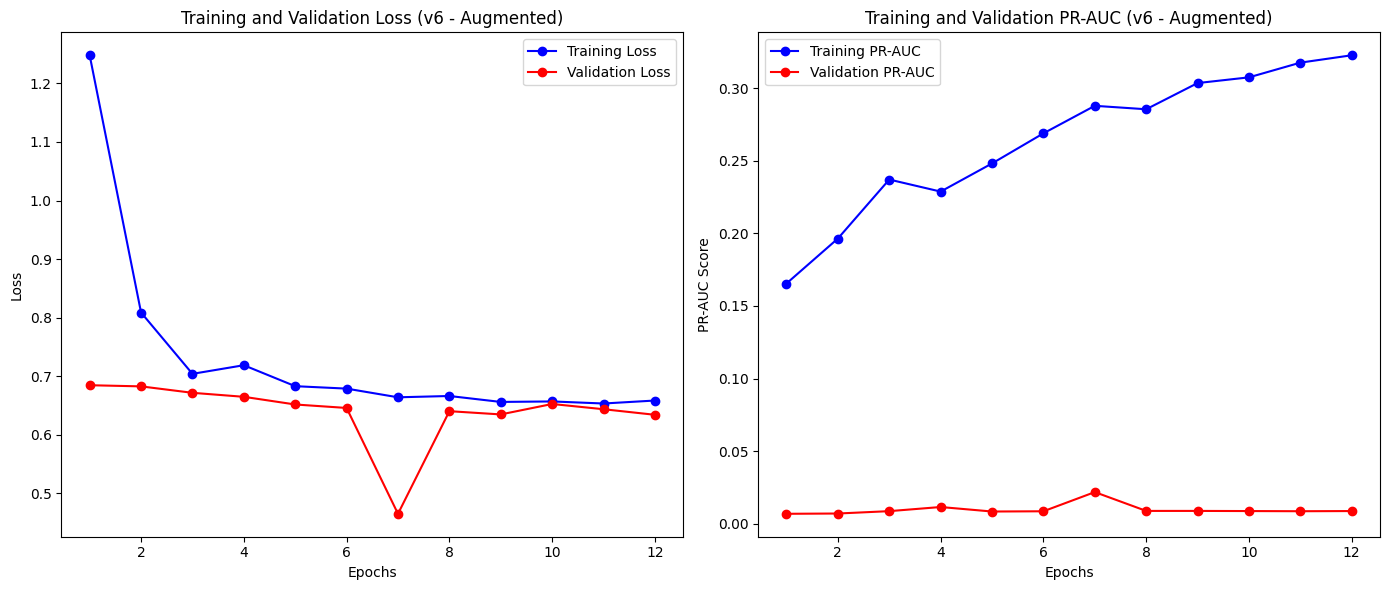

In [9]:
# --- 6. Evaluate the Model (v6) ---
print("Evaluating v6 model (with best weights)...")

y_pred_proba_cnn_v6 = model_v6.predict(X_test_cnn).flatten()
y_pred_cnn_v6 = (y_pred_proba_cnn_v6 > 0.5).astype(int)

print("\nConfusion Matrix (CNN v6):")
cm_cnn_v6 = confusion_matrix(y_test, y_pred_cnn_v6)
print(cm_cnn_v6)

print("\nClassification Report (CNN v6):")
print(classification_report(y_test, y_pred_cnn_v6, target_names=['No Planet (0)', 'Planet (1)']))

# --- 7. Plot Training History ---

print("\nPlotting training history...")
history_dict = history_v6.history
loss = history_dict['loss']; val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']; val_pr_auc = history_dict['val_pr_auc']
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (v6 - Augmented)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('Training and Validation PR-AUC (v6 - Augmented)')
plt.xlabel('Epochs'); plt.ylabel('PR-AUC Score'); plt.legend()
plt.tight_layout()
plt.show()